In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense,Conv1D, Dropout
import matplotlib.pyplot as plt

In [2]:
# Daten einlesen
data = pd.read_csv('final_data_02.csv')

In [3]:
data.head(1)

,R1_1,R1_3,R1_5,R1_7,R1_9,R1_11,R4_1,R4_3,R4_5,R4_7,R4_9,R4_11,Label
0,0.009509,0.002739,0.009983,0.012739,0.043292,0.027413,0.005446,0.013729,0.022559,0.007042,0.014863,0.015488,drill


In [4]:
X = data.drop(['Label'], axis=1)
y = data['Label']



In [5]:
X

,R1_1,R1_3,R1_5,R1_7,R1_9,R1_11,R4_1,R4_3,R4_5,R4_7,R4_9,R4_11
0,0.009509,0.002739,0.009983,0.012739,0.043292,0.027413,0.005446,0.013729,0.022559,0.007042,0.014863,0.015488
1,0.009375,0.002902,0.010054,0.012271,0.042885,0.028700,0.006215,0.012851,0.022911,0.007343,0.015195,0.015166
2,0.008865,0.003296,0.010266,0.013440,0.043616,0.028478,0.005148,0.013241,0.022589,0.006918,0.015198,0.015465
3,0.009710,0.002949,0.010087,0.012824,0.051911,0.029503,0.005121,0.013964,0.022762,0.007152,0.015396,0.015486
4,0.009137,0.002178,0.010328,0.013190,0.043166,0.028862,0.005653,0.013725,0.023074,0.007641,0.015412,0.015303
...,...,...,...,...,...,...,...,...,...,...,...,...
1055,0.009909,0.003685,0.014902,0.025012,0.019150,0.020773,0.006870,0.010924,0.028244,0.009327,0.024279,0.015850
1056,0.012283,0.008089,0.014744,0.034419,0.018611,0.021398,0.006569,0.011272,0.027995,0.010128,0.025185,0.015723
1057,0.012652,0.003050,0.014787,0.034449,0.018964,0.021626,0.006656,0.009906,0.028233,0.009449,0.024658,0.016070
1058,0.012215,0.003331,0.014912,0.034970,0.019104,0.021012,0.006972,0.010424,0.027395,0.009592,0.023784,0.016323


In [6]:
def reciprocal(d):

    # Identify numeric columns
    numeric_columns = d.select_dtypes(include=np.number).columns
    
    # Calculate reciprocal values for non-zero elements and replace zeros with a small value (1e-6)
    d[numeric_columns] = np.where(d[numeric_columns] != 0, 1 / d[numeric_columns], 1e-6)
    
    return d
#data = reciprocal(data)
#data

In [7]:
# Konvertiere Labels in numerische Werte
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [8]:
# Teile die Daten in Trainings- und Testsets auf
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=10 )

In [9]:
# Sliding Window-Technik
window_size = 130

In [10]:
# Erstelle Sliding Windows für Trainingsdaten
X_train_windows = []
y_train_windows = []
for i in range(len(X_train) - window_size):
    X_train_windows.append(X_train.iloc[i:i+window_size])
    y_train_windows.append(y_train[i+window_size])

X_train_windows = np.array(X_train_windows)
y_train_windows = np.array(y_train_windows)

In [11]:
# Erstelle Sliding Windows für Testdaten
X_test_windows = []
y_test_windows = []
for i in range(len(X_test) - window_size):
    X_test_windows.append(X_test.iloc[i:i+window_size])
    y_test_windows.append(y_test[i+window_size])

X_test_windows = np.array(X_test_windows)
y_test_windows = np.array(y_test_windows)

In [12]:
# Überprüfe die Form der Eingabedaten
print("Shape von X_train_windows vor Anpassung:", X_train_windows.shape)

Shape von X_train_windows vor Anpassung: (718, 130, 12)


In [13]:
# Passe die Form der Eingabedaten an
X_train_windows = np.reshape(X_train_windows, (X_train_windows.shape[0], X_train_windows.shape[1], X_train_windows.shape[2]))

In [14]:
# Überprüfe erneut die Form der Eingabedaten
print("Shape von X_train_windows nach Anpassung:", X_train_windows.shape)

Shape von X_train_windows nach Anpassung: (718, 130, 12)


In [15]:
# LSTM-Modell
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train_windows.shape[1], X_train_windows.shape[2])))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

In [16]:
# Kompiliere das Modell
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# Trainiere das Modell
history=model.fit(X_train_windows, y_train_windows, epochs=100, batch_size=64, validation_data=(X_test_windows, y_test_windows))

Epoch 1/100
12/12 [==============================] - 8s 393ms/step - loss: 1.6015 - accuracy: 0.2716 - val_loss: 1.5950 - val_accuracy: 0.2805
Epoch 2/100
12/12 [==============================] - 4s 294ms/step - loss: 1.5882 - accuracy: 0.2869 - val_loss: 1.5999 - val_accuracy: 0.2805
Epoch 3/100
12/12 [==============================] - 3s 279ms/step - loss: 1.5890 - accuracy: 0.2869 - val_loss: 1.5956 - val_accuracy: 0.2805
Epoch 4/100
12/12 [==============================] - 4s 297ms/step - loss: 1.5903 - accuracy: 0.2869 - val_loss: 1.5967 - val_accuracy: 0.2805
Epoch 5/100
12/12 [==============================] - 4s 341ms/step - loss: 1.5895 - accuracy: 0.2869 - val_loss: 1.5958 - val_accuracy: 0.2805
Epoch 6/100
12/12 [==============================] - 5s 385ms/step - loss: 1.5856 - accuracy: 0.2869 - val_loss: 1.5985 - val_accuracy: 0.2805
Epoch 7/100
12/12 [==============================] - 4s 326ms/step - loss: 1.5881 - accuracy: 0.2869 - val_loss: 1.5941 - val_accuracy: 0.2805

In [18]:
# Überprüfe die Form der Testdaten
print("Shape von X_test_windows vor Anpassung:", X_test_windows.shape)

Shape von X_test_windows vor Anpassung: (82, 130, 12)


In [19]:
# Passe die Form der Testdaten an
X_test_windows = np.reshape(X_test_windows, (X_test_windows.shape[0], X_test_windows.shape[1], X_test_windows.shape[2]))

In [20]:
# Überprüfe erneut die Form der Testdaten
print("Shape von X_test_windows nach Anpassung:", X_test_windows.shape)

Shape von X_test_windows nach Anpassung: (82, 130, 12)


In [21]:
# Evaluieren des Modells
y_pred = model.predict(X_test_windows)
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_labels)

3/3 [==============================] - 1s 46ms/step


In [22]:
# Konvertiere vorhergesagte Labels in Label-Strings
y_test_labels = label_encoder.inverse_transform(y_test_windows)

In [23]:
# Berechne die Genauigkeit
accuracy = accuracy_score(y_test_labels, y_pred_labels)

In [24]:
# Gib jedes Element der vorhergesagten und tatsächlichen Labels aus
for pred_label, true_label in zip(y_pred_labels, y_test_labels):
    print("Predicted Label:", pred_label)
    print("True Label:", true_label)
    print("------------------------------------------------------")

print("Accuracy:", accuracy)

Predicted Label: sanding
True Label: sanding
------------------------------------------------------
Predicted Label: sanding
True Label: sanding
------------------------------------------------------
Predicted Label: sanding
True Label: lifting
------------------------------------------------------
Predicted Label: sanding
True Label: screw
------------------------------------------------------
Predicted Label: painting
True Label: screw
------------------------------------------------------
Predicted Label: painting
True Label: painting
------------------------------------------------------
Predicted Label: painting
True Label: sanding
------------------------------------------------------
Predicted Label: painting
True Label: screw
------------------------------------------------------
Predicted Label: painting
True Label: lifting
------------------------------------------------------
Predicted Label: painting
True Label: drill
------------------------------------------------------
P

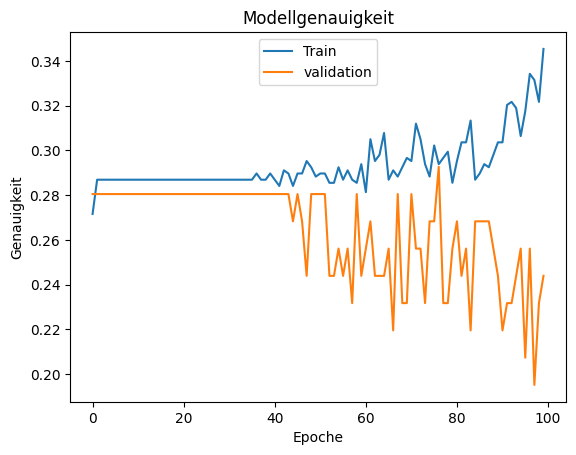

In [25]:
# Plot der Trainings- und Validierungsgenauigkeit
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modellgenauigkeit')
plt.ylabel('Genauigkeit')
plt.xlabel('Epoche')
plt.legend(['Train', 'validation'], loc='upper center')
plt.show()